In [1]:
!pip install --upgrade ddqla

  Obtaining dependency information for ddqla from https://files.pythonhosted.org/packages/4e/18/03d888790ec62b8ceef1df54e9fb3a63077c8728b038b134c53ee229fb86/ddqla-0.1.14-py3-none-any.whl.metadata
  Attempting uninstall: ddqla
    Found existing installation: ddqla 0.1.13
    Uninstalling ddqla-0.1.13:
      Successfully uninstalled ddqla-0.1.13


In [2]:
import numpy as np
import pandas as pd

from ddqla.agents import BaseAgent

from keras.models import Model
from keras.layers import Dense, Input
from keras.optimizers import Adam
from keras.losses import MeanSquaredError

In [3]:
class PacchiAgent(BaseAgent):
    __ACTIONS = 4

    def __init__(self):
        super().__init__(
            num_actions=PacchiAgent.__ACTIONS,
            environment=np.asarray([0, 0], dtype=np.float32),
            fit_each_n_steps = 5,
            exploration_rate_decay = 1e-3,
            cumulative_rewards_max_length=250,
            memory_max_length=512,
            memory_batch_size=128,
        )

    def _get_model(self, environment):
        inputs = Input(shape=(environment))
        dense = Dense(8, activation='swish')(inputs)
        dense = Dense(8, activation='swish')(dense)
        outputs = Dense(PacchiAgent.__ACTIONS, activation='linear')(dense)

        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(), loss=MeanSquaredError())
        model.summary()

        return model

    def reset_state(self):
        self._state = np.asarray([0, 0], dtype=np.float32)

    def _get_reward(self, action, environment):
        reward = -1
        if action == 0 and environment[0] == 0:  #  prendi pacco
            environment[1] = 1 # pacco preso
        elif action == 1:  # lascia il pacco
            if environment[1] == 1:
                environment[1] = 0  # no pacco
                if environment[0] == 1:
                    reward = 5  # 4 azioni per raggiungere lo scopo
        elif action == 2:  #  vai a magazzino 2
            environment[0] = 1  # sono in magazzino 2
        elif action == 3:  # vai a magazzino 1
            environment[0] = 0
        return reward

In [4]:
a = PacchiAgent()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 8)                 24        
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
Total params: 132 (528.00 Byte)
Trainable params: 132 (528.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input

In [5]:
a = PacchiAgent()
for s in range(0, 6000):
    a.step()
    if s % 100 == 0 and a.is_memory_ready():
        test_rewards = a.test(64)
        cum_rewards = a.get_last_cumulative_rewards()
        print("#", s, " CR: ", cum_rewards, " R: ", test_rewards)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_6 (Dense)             (None, 8)                 24        
                                                                 
 dense_7 (Dense)             (None, 8)                 72        
                                                                 
 dense_8 (Dense)             (None, 4)                 36        
                                                                 
Total params: 132 (528.00 Byte)
Trainable params: 132 (528.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inp

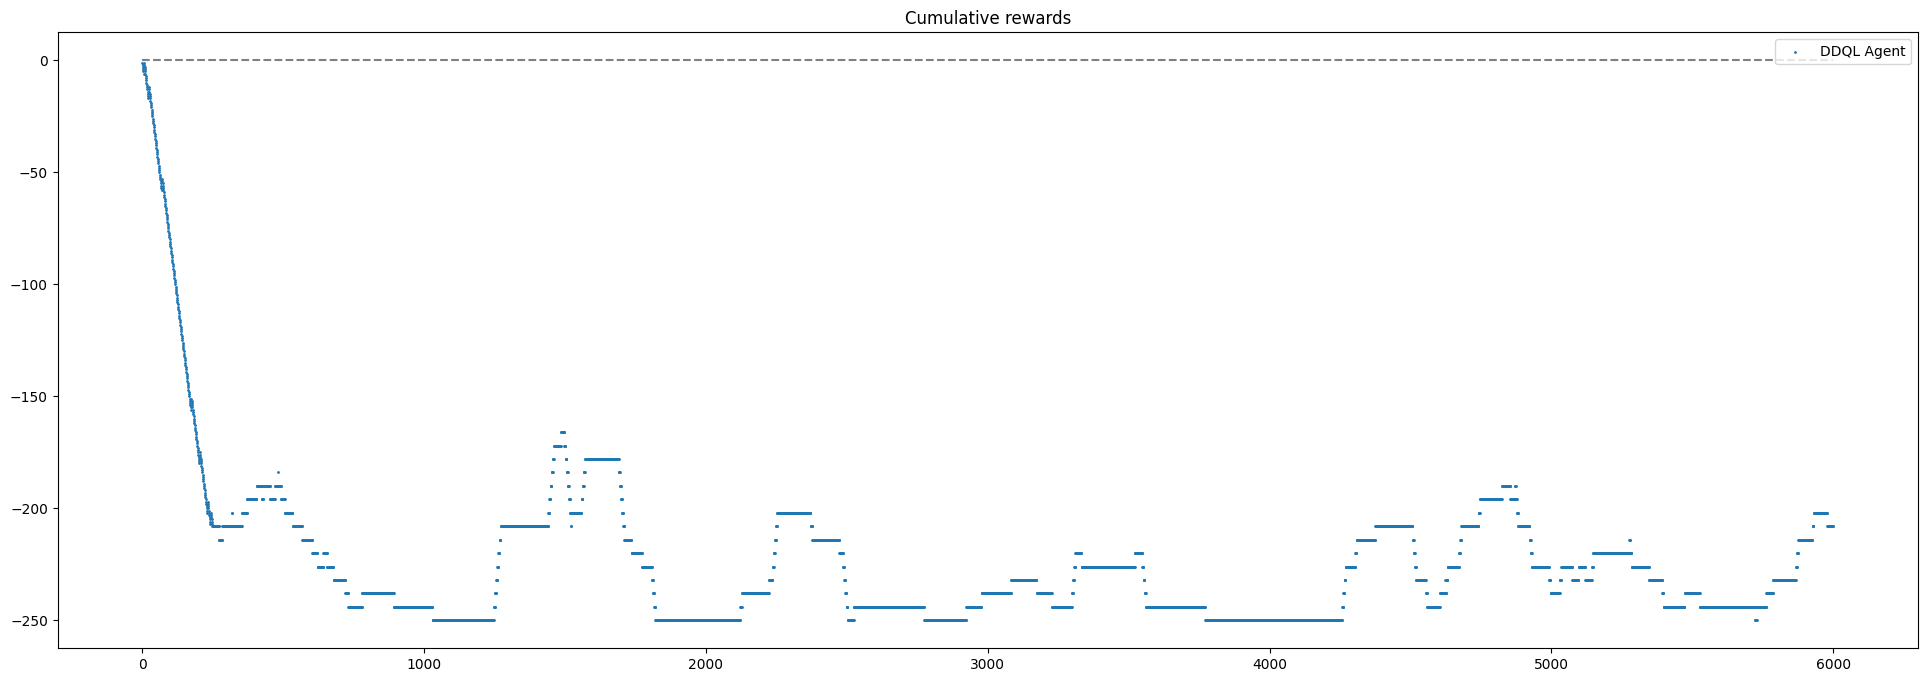

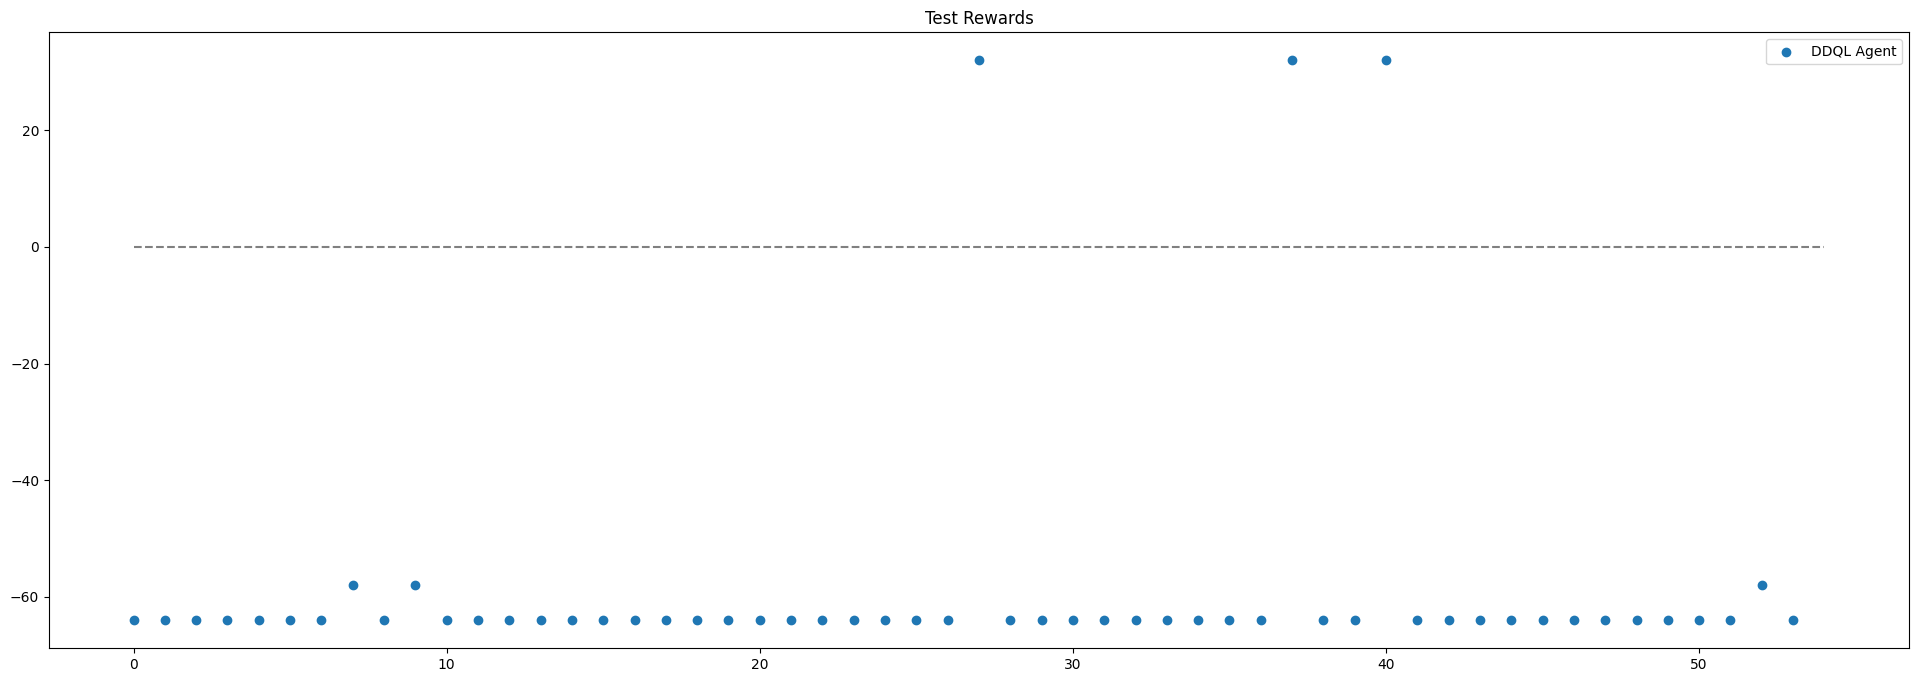

In [6]:
a.summary()

In [7]:
#il file fisicamente lo trovate nella cartella colab
a.save_simulation_log(append_ts=False)

#Legenda
- **step**: numero sequenziale dello step
- **state_x**: valore dell'ambiente nella cella di posizione x
- **p1_x**: valori assunti dal modello 1 alla posizione x
- **p2_x**: valori assunti dal modello 1 alla posizione x
- **q_x**: valori assunti dal qtable alla posizione x
- **rnd**: valore random generato in quello step, se > er usa i modelli per predirre se no sceglie un'azione randomica
- **er**: exploration rate attuale
- **action**: azione scelta
- **reward**: reward restituita per quell'azione
- **cum_reward**: reward cumulativa in quel momento

In [8]:
df = pd.read_csv("simulation_log.csv", delimiter=";")
df

,step,state_0,state_1,p1_0,p1_1,p1_2,p1_3,p2_0,p2_1,p2_2,p2_3,q_0,q_1,q_2,q_3,rnd,er,action,reward,cum_reward
0,1,0.0,1.0,-0.106163,-0.044135,0.132252,-0.250360,-0.124259,0.019720,-0.292946,-0.052468,-0.124259,-0.044135,-0.292946,-0.250360,0.753890,0.999,0,-1,-1
1,2,0.0,1.0,-0.106163,-0.044135,0.132252,-0.250360,-0.124259,0.019720,-0.292946,-0.052468,-0.124259,-0.044135,-0.292946,-0.250360,0.111348,0.998,0,-1,-2
2,3,1.0,1.0,-0.012603,-0.018224,0.179850,-0.178848,-0.144482,-0.095484,-0.181876,-0.259447,-0.144482,-0.095484,-0.181876,-0.259447,0.941960,0.997,2,-1,-3
3,4,1.0,1.0,-0.012603,-0.018224,0.179850,-0.178848,-0.144482,-0.095484,-0.181876,-0.259447,-0.144482,-0.095484,-0.181876,-0.259447,0.377757,0.996,0,-1,-4
4,5,1.0,1.0,-0.012603,-0.018224,0.179850,-0.178848,-0.144482,-0.095484,-0.181876,-0.259447,-0.144482,-0.095484,-0.181876,-0.259447,0.716153,0.995,2,-1,-5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,5996,1.0,0.0,-2.769263,-2.721807,-2.824080,-2.710590,-2.764692,-2.709117,-2.821971,-2.703057,-2.769263,-2.721807,-2.824080,-2.710590,0.963864,0.050,2,-1,-208
5996,5997,0.0,0.0,-2.757214,-2.777334,-2.729546,-2.927028,-2.750887,-2.779456,-2.720798,-2.928507,-2.757214,-2.779456,-2.729546,-2.928507,0.681236,0.050,3,-1,-208
5997,5998,1.0,0.0,-2.769263,-2.721807,-2.824080,-2.710590,-2.764692,-2.709117,-2.821971,-2.703057,-2.769263,-2.721807,-2.824080,-2.710590,0.066165,0.050,2,-1,-208
5998,5999,0.0,0.0,-2.757214,-2.777334,-2.729546,-2.927028,-2.750887,-2.779456,-2.720798,-2.928507,-2.757214,-2.779456,-2.729546,-2.928507,0.892536,0.050,3,-1,-208
